# ZI_scope (MFLI edittion)

In [10]:
import zhinst.utils
import zhinst.ziPython
import time
import matplotlib.pyplot as plt

In [11]:
class device_setup:
    
    def __init__(self,device_id):
        self.device_serial = device_id
        self.device_id = device_id
        self.device = 'data has not loaded'
        self.daq = 'data has not loaded'
        self.props ='data has not loaded'
        self.sweep = 'not active'
        self.samples_sweep ='data has not loaded'

        
    def discov_device(self, disa_all_output = False):
        # Settings
        apilevel_example = 5  # The API level for MF series.
        err_msg = "This example only ran on MF series"

        (self.daq, self.device, self.props) = zhinst.utils.create_api_session(self.device_id, apilevel_example,)
        
        zhinst.utils.api_server_version_check(self.daq)
        
        if disa_all_output:
            # Create a base configuration: Disable all available outputs, awgs, demods, scopes,...
            zhinst.utils.disable_everything(self.daq, self.device)
            print('Disable all available outputs, scopes,...')

    def sigout_on(self):
        
        self.daq.setInt("/%s/sigouts/0/on" % self.device,1)
        
    def sigout_off(self):
        self.daq.setInt("/%s/sigouts/0/on" % self.device,0)
        
    def MOD_off(self):
        
        #diable the modulation amplitude
        self.daq.setInt("/%s/mods/0/sidebands/0/enable" % self.device,0)
        
        #diable the MOD
        self.daq.setInt("/%s/mods/0/enable" % self.device,0) 
    
    def sweep_params(self,start=300e3,stop=450e3,points=400,ac_sweep_amp=0.5):
        
        self.start = start
        self.stop = stop
        self.points = points
        self.amplitude = ac_sweep_amp 
        
    def do_sweep_frq(self, amp_MOD=False ,do_plot=True):
        
        out_channel = 0
        out_mixer_channel = zhinst.utils.default_output_mixer_channel(self.props)
        in_channel = 0
        demod_index = 0
        demod_index_lowSB = 1
        demod_index_highSB = 2
        osc_index = 0
        demod_rate = 10e3
        time_constant = 0.01

        exp_setting = [
            ["/%s/sigins/%d/ac" % (self.device, in_channel), 1],
            ["/%s/sigins/%d/range" % (self.device, in_channel), 4 * self.amplitude],
            ["/%s/demods/%d/enable" % (self.device, demod_index), 1],
            ["/%s/demods/%d/rate" % (self.device, demod_index), demod_rate],
            ["/%s/demods/%d/adcselect" % (self.device, demod_index), in_channel],
            ["/%s/demods/%d/order" % (self.device, demod_index), 4],
            ["/%s/demods/%d/timeconstant" % (self.device, demod_index), time_constant],
            ["/%s/demods/%d/oscselect" % (self.device, demod_index), osc_index],
            ["/%s/demods/%d/harmonic" % (self.device, demod_index), 1],
            ["/%s/sigouts/%d/on" % (self.device, out_channel), 1],
            ["/%s/sigouts/%d/enables/%d" % (self.device, out_channel, out_mixer_channel), 1],
            ["/%s/sigouts/%d/range" % (self.device, out_channel), 1],
            ["/%s/sigouts/%d/amplitudes/%d" % (self.device, out_channel, out_mixer_channel), self.amplitude],
        ]

        self.daq.set(exp_setting)

        # Perform a global synchronisation between the device and the data server:
        # Ensure that 1. the settings have taken effect on the device before issuing
        # the poll() command and 2. clear the API's data buffers.
        self.daq.sync()

        # Create an instance of the Sweeper Module (ziDAQSweeper class).
        sweeper = self.daq.sweep()

        # Configure the Sweeper Module's parameters.
        # Set the device that will be used for the sweep - this parameter must be set.
        sweeper.set("device", self.device)
        
        # Specify the `gridnode`: The instrument node that we will sweep, the device
        # setting corresponding to this node path will be changed by the sweeper.
        osc_index = 0
        sweeper.set("gridnode", "oscs/%d/freq" % osc_index)
        # Set the `start` and `stop` values of the gridnode value interval we will use in the sweep.
        sweeper.set("start", self.start)
        sweeper.set("stop", self.stop)
        # Set the number of points to use for the sweep, the number of gridnode
        # setting values will use in the interval (`start`, `stop`).
        samplecount = self.points
        sweeper.set("samplecount", samplecount)
        # Specify logarithmic spacing for the values in the sweep interval.
        sweeper.set("xmapping", 1)
        # Automatically control the demodulator bandwidth/time constants used.
        # 0=manual, 1=fixed, 2=auto
        # Note: to use manual and fixed, bandwidth has to be set to a value > 0.
        sweeper.set("bandwidthcontrol", 2)
        # Sets the bandwidth overlap mode (default 0). If enabled, the bandwidth of
        # a sweep point may overlap with the frequency of neighboring sweep
        # points. The effective bandwidth is only limited by the maximal bandwidth
        # setting and omega suppression. As a result, the bandwidth is independent
        # of the number of sweep points. For frequency response analysis bandwidth
        # overlap should be enabled to achieve maximal sweep speed (default: 0). 0 =
        # Disable, 1 = Enable.
        sweeper.set("bandwidthoverlap", 0)

        # Sequential scanning mode (as opposed to binary or bidirectional).
        sweeper.set("scan", 0)
        # Specify the number of sweeps to perform back-to-back.
        loopcount = 1
        sweeper.set("loopcount", loopcount)
        # We don't require a fixed settling/time since there is no DUT
        # involved in this example's setup (only a simple feedback cable), so we set
        # this to zero. We need only wait for the filter response to settle,
        # specified via settling/inaccuracy.
        sweeper.set("settling/time", 0)
        # The settling/inaccuracy' parameter defines the settling time the
        # sweeper should wait before changing a sweep parameter and recording the next
        # sweep data point. The settling time is calculated from the specified
        # proportion of a step response function that should remain. The value
        # provided here, 0.001, is appropriate for fast and reasonably accurate
        # amplitude measurements. For precise noise measurements it should be set to
        # ~100n.
        # Note: The actual time the sweeper waits before recording data is the maximum
        # time specified by settling/time and defined by
        # settling/inaccuracy.
        sweeper.set("settling/inaccuracy", 0.001)
        # Set the minimum time to record and average data to 10 demodulator
        # filter time constants.
        sweeper.set("averaging/tc", 10)
        # Minimal number of samples that we want to record and average is 100. Note,
        # the number of samples used for averaging will be the maximum number of
        # samples specified by either averaging/tc or averaging/sample.
        sweeper.set("averaging/sample", 10)

        # Now subscribe to the nodes from which data will be recorded. Note, this is
        # not the subscribe from ziDAQServer; it is a Module subscribe. The Sweeper
        # Module needs to subscribe to the nodes it will return data for.x
        self.daq.setInt("/%s/sigouts/0/on" % self.device,1)
        self.daq.setInt("/%s/demods/0/enable" % self.device,1)
        
        sweeper.set('sweep/endless',0)        
        demod_index = 0
        path = "/%s/demods/%d/sample" % (self.device, demod_index)
        sweeper.get(path)
        sweeper.subscribe(path)
         
        # Start the Sweeper's thread.
        sweeper.execute()
        data = sweeper.read()

        start = time.time()
#         timeout = 60  # [s]
        timeout = 30  # [s]
        #print("Will perform", loopcount, "frequency sweeps...")
        while not sweeper.finished():  # Wait until the sweep is complete, with timeout.
            time.sleep(0.2)
            progress = sweeper.progress()
            print(f"Sweep progress: {progress[0]:.2%}.", end="\r")
            # Here we could read intermediate data via:
            # data = sweeper.read(True)...
            # and process it while the sweep is completing.
            # if device in data:
            # ...
            if (time.time() - start) > timeout:
                # If for some reason the sweep is blocking, force the end of the
                # measurement.
                print("\nSweep still not finished, forcing finish...")
                self.daq.sync()
                sweeper.finish()
        print("")
        
        # Read the sweep data. This command can also be executed whilst sweeping
        # (before finished() is True), in this case sweep data up to that time point
        # is returned. It's still necessary still need to issue read() at the end to
        # fetch the rest.
        
        sweeper.unsubscribe(path)        
        return_flat_dict = True
        data = sweeper.read(return_flat_dict)
        

        self.daq.setInt("/%s/sigouts/0/on" % self.device,0)

            
        # Check the dictionary returned is non-empty.
        assert data, "read() returned an empty data dictionary, did you subscribe to any paths?"
        # Note: data could be empty if no data arrived, e.g., if the demods were
        # disabled or had rate 0.
        assert path in data, "No sweep data in data dictionary: it has no key '%s'" % path
        samples = data[path]
        #print("Returned sweeper data contains", len(samples), "sweeps.")
        assert len(samples) == loopcount, "The sweeper returned an unexpected number of sweeps: `%d`. Expected: `%d`." % (
            len(samples),
            loopcount,
        )

        if do_plot:
            
#             if (amp_MOD == True):
                
#                 mod_read = data['/dev2451/demods/1/sample']

#                 mod_freq = data['/dev2451/demods/0/sample'][0][0]['frequency']
                
#                 #Center
#                 mod_mid_amp = np.abs(data['/dev2451/demods/0/sample'][0][0]['x'] 
#                                       + 1j * data['/dev2451/demods/0/sample'][0][0]['y']) 
#                 mod_mid_phase = np.angle(data['/dev2451/demods/0/sample'][0][0]['x'] 
#                                           + 1j * data['/dev2451/demods/0/sample'][0][0]['y'])
#                 #R2
#                 mod_left_amp = np.abs(data['/dev2451/demods/1/sample'][0][0]['x'] 
#                                       + 1j * data['/dev2451/demods/1/sample'][0][0]['y']) 
#                 mod_left_phase = np.angle(data['/dev2451/demods/1/sample'][0][0]['x'] 
#                                           + 1j * data['/dev2451/demods/1/sample'][0][0]['y'])
#                 #R3
#                 mod_right_amp = np.abs(data['/dev2451/demods/2/sample'][0][0]['x'] 
#                                       + 1j * data['/dev2451/demods/2/sample'][0][0]['y']) 
#                 mod_right_phase = np.angle(data['/dev2451/demods/2/sample'][0][0]['x'] 
#                                           + 1j * data['/dev2451/demods/2/sample'][0][0]['y'])

#                 #fig2 = plt.figure(figsize=(8,10))
#                 fig2 = plt.figure()
#                 fig2.add_subplot(2,1, 1)
#                 plt.plot(mod_freq,mod_left_amp,'r')
#                 plt.plot(mod_freq,mod_mid_amp,'b--')
#                 plt.plot(mod_freq,mod_right_amp,'g')
#                 plt.title("frequency sweep")
#                 plt.grid()
#                 plt.ylabel(r"Amp ($V_\mathrm{RMS}$)")
#                 plt.autoscale()

#                 fig2.add_subplot(2,1, 2)
#                 plt.plot(mod_freq,mod_left_phase,'r')
#                 plt.plot(mod_freq,mod_mid_phase,'b--')
#                 plt.plot(mod_freq,mod_right_phase,'g')
#                 plt.grid()
#                 plt.xlabel("Frequency ($Hz$)")
#                 plt.ylabel(r"Phase (radians)")
#                 plt.autoscale()
                
#                 plt.draw()
#                 plt.show()
                
#                 self.diff_R_vec = mod_right_amp - mod_left_amp
#                 self.sweep_frq_vec = mod_freq
#                 self.cal_gain()
#                 self.MOD_on()
#                 print("AM modulation enabled")
#                 print("Carrier signal disabled")
                

            
#             elif (amp_MOD == False):
            _, (ax1, ax2) = plt.subplots(2, 1)

            for sample in samples:
                frequency = sample[0]["frequency"]
                R = np.abs(sample[0]["x"] + 1j * sample[0]["y"])
                phi = np.angle(sample[0]["x"] + 1j * sample[0]["y"])
                ax1.plot(frequency, R, 'b')
                ax2.plot(frequency, phi, 'b')
            ax1.set_title("frequency sweep")
            ax1.grid()
            ax1.set_ylabel(r"Amp ($V_\mathrm{RMS}$)")
            ax1.autoscale()

            ax2.grid()
            ax2.set_xlabel("Frequency ($Hz$)")
            ax2.set_ylabel(r"Phase (radians)")
            ax2.autoscale()

            plt.draw()
            plt.show()

            self.samples_sweep = samples
            R = np.abs(sample[0]["x"] + 1j * sample[0]["y"])
            print('resonance frequency = '+str(round(((sample[0]["frequency"][np.argmax(R, axis=0)])/1e3),4))+" kHz")

    def setup_scope(self):
        
        BE_enable = self.BE_enable
        # Configure the Scope for measurement
        # 'channels/0/inputselect' : the input channel for the scope:
        #   0 - signal input 1
        #   48 = amplitude

        #Chanel 1
        self.daq.setInt("/%s/scopes/0/channels/0/inputselect" % (self.device), 1)

        #Chanel 2
#         self.daq.setInt("/%s/scopes/0/channels/1/inputselect" % (self.device), 1)

        # Activate scpope chanel 1 and 2 
        self.daq.setInt("/%s/scopes/0/channel" % (self.device), 3) # number 3 mean activate 2 chanels
        self.daq.sync()

        # 'time' : timescale of the wave, sets the sampling rate to 1.8GHz/2**time.
        #   0 - sets the sampling rate to 1.8 GHz
        #   1 - sets the sampling rate to 900 MHz
        #   ...
        #   16 - sets the sampling rate to 27.5 kHz
        self.daq.setInt("/%s/scopes/0/time" % self.device, 10)  # Same with the option in AWG
        
#         self.daq.setDouble('/dev2584/scopes/0/trigdelay', 0.05)
#         self.daq.setDouble('/dev2584/scopes/0/triglevel', 0.05)

        # 'single' : only get a single scope shot.
        #   0 - take continuous shots
        #   1 - take a single shot
        # Disable the scope.
        self.daq.setInt("/%s/scopes/0/enable" % self.device, 0)
        
        
        # Configure the length of the scope shot.      
#         self.AWG_N_for_scope = int(len(self.BEPS_wave))   
        self.AWG_N_for_scope = int(len(BE_wave)) 
        
        self.daq.setInt("/%s/scopes/0/length" % self.device, self.AWG_N_for_scope)       
        
        # Now configure the scope's trigger to get aligned data
        # 'trigenable' : enable the scope's trigger (boolean).
        
        #turn on Singnal Input 1
        self.daq.setInt("/%s/sigins/0/ac" % self.device, 1) # signal in channel 0, AC on
#         self.daq.setInt("/%s/sigins/0/ac" % self.device, 0) # signal in channel 0, AC off
        
        # all impedacne maching off
        self.daq.setInt("/%s/sigins/0/imp50" % self.device, 0)
        self.daq.setInt("/%s/sigouts/0/imp50" % self.device, 0)
        self.daq.setInt("/%s/sigins/1/imp50" % self.device, 0)
        self.daq.setInt("/%s/sigouts/1/imp50" % self.device, 0)   
    
    
    def setup_trigger(self):   
    
        ####### set the generation rate #################
        # 'time' : timescale of the wave, sets the sampling rate to 1.8GHz/2**time.
        #   0 - sets the sampling rate to 1.8 GHz
        #   1 - sets the sampling rate to 900 MHz
        #   ...
        #   16 - sets the sampling rate to 27.5 kHz
        self.daq.setInt("/%s/awgs/0/time"% self.device, 10)


        
        self.daq.setInt("/%s/scopes/0/trigenable" % self.device, 1)
        # Specify the trigger channel:
        #
        # Here we trigger on the signal from UHF signal input 1. If the instrument has the DIG Option installed we could
        # trigger the scope using an AWG Trigger instead (see the `setTrigger(1);` line in `awg_program` above).
        # 0:   Signal Input 1
        # 192: AWG Trigger 1
        # 2: Trigger Input 1
        trigchannel = 2
        print("Trigger channel avialble at 'Trigger 1'")
        self.daq.setInt("/%s/scopes/0/trigchannel" % self.device, trigchannel)
        self.daq.sync()

        if trigchannel == 0:
            # Trigger on the falling edge of the negative blackman waveform `w0` from our AWG program.
            self.daq.setInt("/%s/scopes/0/trigslope" % self.device, 2)
            self.daq.setDouble("/%s/scopes/0/triglevel" % self.device, -0.600)
            # Set hysteresis triggering threshold to avoid triggering on noise
            # 'trighysteresis/mode' :
            #  0 - absolute, use an absolute value ('scopes/0/trighysteresis/absolute')
            #  1 - relative, use a relative value ('scopes/0trighysteresis/relative') of the trigchannel's input range
            #      (0.1=10%).
            self.daq.setDouble("/%s/scopes/0/trighysteresis/mode" % self.device, 0)
            self.daq.setDouble("/%s/scopes/0/trighysteresis/relative" % self.device, 0)
#             self.daq.setDouble("/%s/scopes/0/trighysteresis/relative" % self.device, 0.025)
            # Set a negative trigdelay to capture the beginning of the waveform.
            trigdelay = 0.00
            self.daq.setDouble("/%s/scopes/0/trigdelay" % self.device, trigdelay)
        else:
            # Assume we're using an AWG Trigger, then the scope configuration is simple: Trigger on rising edge.
            self.daq.setInt("/%s/scopes/0/trigslope" % self.device, 1)
            self.daq.setDouble("/%s/scopes/0/triglevel" % self.device, 0.1) # 0.3 = 300mV
            # Set trigdelay to 0.0: Start recording from when the trigger is activated.
            trigdelay = 0.00
            self.daq.setDouble("/%s/scopes/0/trigdelay" % self.device, trigdelay)
        trigreference = 0.0
        # The trigger reference position relative within the wave, a value of 0.5 corresponds to the center of the wave.
        self.daq.setDouble("/%s/scopes/0/trigreference" % self.device, trigreference)
        self.daq.setDouble("/%s/sigins/0/range" % self.device, 1.5);
        # Set the hold off time in-between triggers.
        self.daq.setDouble("/%s/scopes/0/trigholdoff" % self.device, 0.025)

    
    def turn_off_sigouts(self):
#         self.daq.setInt('/dev2451/sigouts/0/enables/0', 0)
#         self.daq.setInt('/dev2451/sigouts/1/enables/0', 0)
#         self.daq.setInt('/dev2451/demods/0/enable', 0)

        self.daq.setInt("/%s/sigouts/0/on" % self.device,0)
        self.daq.setInt("/%s/sigouts/0/enables/1" % self.device,0)
        self.daq.setInt("/%s/sigouts/0/add" % self.device,0)
        self.daq.setInt("/%s/demods/0/enable" % self.device,0)
        
#         self.daq.setInt('/dev2584/sigouts/0/on', 0)
#         self.daq.setInt('/dev2584/sigouts/0/enables/0', 0)
#         self.daq.setInt('/dev2584/sigouts/0/add', 0)
#         self.daq.setInt('/dev2584/demods/0/enable', 0)
        
    def single_point_BEPFM(self):
        
#         self.datamat = np.zeros((1,2,self.AWG_N_for_scope))
#         self.input_sig = np.zeros((1,1,self.AWG_N_for_scope))
        
        print("waiting for trigger")
        
        t1 = time.time()
        self.daq.setInt("/%s/sigouts/0/on" % self.device, 1)  # signal outputs 1 on
        self.daq.setInt("/%s/sigouts/1/on" % self.device, 1)  # signal outputs 2 on
        self.daq.sync()
        
        # Set up the Scope Module.
        scopeModule = self.daq.scopeModule()
        scopeModule.set("mode", 1)
        scopeModule.subscribe(f"/{self.device}/scopes/0/wave")
#         self.daq.setInt("/%s/scopes/0/single" % self.device, 1)
        self.daq.setInt("/%s/scopes/0/single" % self.device, 0)
#         scopeModule.set('averager/weight', 3)
#         scopeModule.set('averager/restart', 0)

        scopeModule.execute()

        # set-up the AWG trigger
        self.daq.setDouble("/%s/triggers/in/0/level" % self.device, 0.5) # 0.3 = 300mV
        self.daq.sync()

        # Start the AWG in single-shot mode.
        # This is the preferred method of using the AWG: Run in single mode continuous waveform playback is best achieved by
        # using an infinite loop (e.g., while (true)) in the sequencer program.
        #self.daq.set([[f"/{self.device}/awgs/0/single", 1], [f"/{self.device}/awgs/0/enable", 1]])
        self.daq.set([[f"/{self.device}/awgs/0/single", 0], [f"/{self.device}/awgs/0/enable", 1]])
        self.daq.sync()

        # Start the scope...
        self.daq.setInt("/%s/scopes/0/enable" % self.device, 1)
        self.daq.sync()
        time.sleep(0.1)

        self.daq.setInt("/%s/awgs/0/userregs/0" % self.device, 1)
        
        self.daq.sync()
        
        
        t2 = time.time()
        #Delay the of reading data from scope
        def do_records(scopeModule ):
            time.sleep(
            ) #extra sleep time before record
            records = scopeModule.getInt("records")
            return records
        
        # Read the scope data with timeout.
        local_timeout = 10.0

        records = 0
        while (records < 1) and (local_timeout > 0):
            time.sleep(0.1)
            local_timeout -= 0.1
            
            records = scopeModule.getInt("records")
            #records = do_records(scopeModule )
            
        if local_timeout < 0:
            raise Exception("trigger waiting timeout")
            
        # Disable the scope.
        self.daq.setInt("/%s/scopes/0/enable" % self.device, 0)
        self.daq.sync()

        data_read = scopeModule.read(True)    

        self.wave_from_scope = np.squeeze(data_read['/dev2584/scopes/0/wave'][0][0]['wave'])
#         wave_from_scope = data_read['/dev2584/scopes/0/wave'][0][0]['wave']
        self.response_wave = self.wave_from_scope[0,:] # response in channel 1

Trying to connect to dev4428 on interface PCIe
Connected to dev4428 via data server 192.168.69.50:8004 and interface PCIe
Disable all available outputs, scopes,...
Sweep progress: 100.00%.


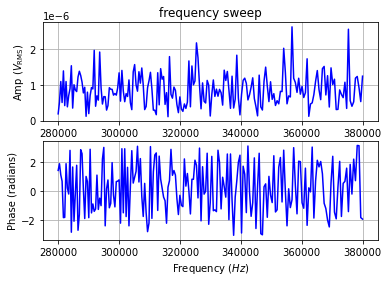

resonance frequency = 356.8278 kHz


In [12]:
device_id = 'dev4428'
A1 = device_setup(device_id)
A1.discov_device(disa_all_output = True)
A1.sweep_params(start=280e3,stop=380e3,points=200,ac_sweep_amp=1)
A1.do_sweep_frq()
# A1.sigout_on()
# A1.turn_off_sigouts()
# A1.sigout_off()